# This is a tutorial for how to use a learned neural network (encoder + decoder) to encode songs and decode songs

In [46]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
sys.path.append('..')

In [24]:
import numpy as np
import matplotlib.pyplot as plt

##  DATA PREP : In this section, we'll do the following steps:

    1. Load a wav file 
    2. Downsample it
    3. Convert to spectrogram (keep only magnitude)
    4. Transform spectrogram (log power)
    

In [7]:
# import these functions
from data.create_hdf_dataset import load_wav_file, downsample, to_image
from utils.utils import transform, rescale_spectrogram

In [27]:
path_to_wav_file = '/home/gagan/data/zudeep/models/nz_16_layernorm/2020-02-12_15-54-45.559201/input_audio_epoch_000_batchnumb_2000.wav'

load the file 

In [28]:
sequence, fs = load_wav_file(path_to_wav_file)

# this is your loaded wav file as a numpy array
sequence.shape

(18432,)

In [29]:
fs

16000

Downsample it 

In [ ]:
sequence = downsample(sequence, down_factor=2)

Convert to spectrogram

In [30]:
# IMPORTANT : nfft = 256 is needed for convolutional networks shape! 
spect = to_image(sequence, nfft = 256)

# this is actually a short time fourier transform, so it returns the absolute value (last axis of array, dim = 0) and angle (last axis, dim=1)
spect.shape

(129, 291, 2)

Transform to only magnitude , log-power (log( spect + 1) is used)

In [31]:
spect = transform(spect)

In [32]:
spect.shape

(129, 291)

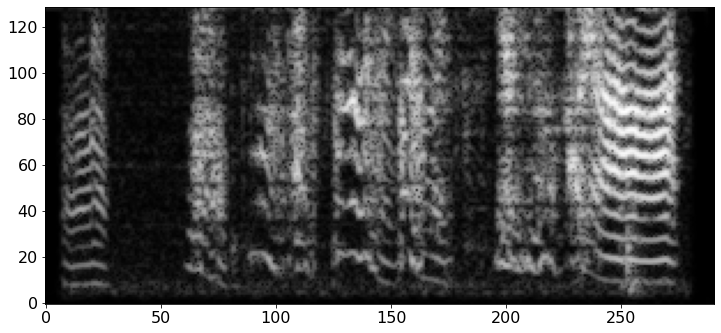

In [33]:
plt.figure(figsize=(12,6))
plt.imshow(rescale_spectrogram(spect), origin='lower', cmap='gray')
plt.show()

# load networks 

## Now lets load the encoder and decoder networks

In [59]:
from utils.utils import load_netE, load_netG

In [60]:
help(load_netE)

Help on function load_netE in module utils.utils:

load_netE(netE_file_path, nz=16, ngf=128, nc=1, cuda=False, resnet=False)
    Load the encoder network
    
    Params
    ------
        netE_file_path : str, location of encoder network file (torch state_dict)
        nz : int, number of latent dimensions
        ngf : int, multiplier of number of filters per conv layers
        nc : int, (leave 1) number of channels (usually just gray-scale)
        cuda : bool, whether to put on gpu (default device 0)
        resnet : bool, whether this is a resnet type model
    
    Returns
    -------
        netE : encoder network



In [37]:
netGpath = '/home/gagan/data/zudeep/models/nz_12_residual/2021-05-05_10-41-37.547480/netG_epoch_6.pth'
netEpath = '/home/gagan/data/zudeep/models/nz_12_residual/2021-05-05_10-41-37.547480/netE_epoch_6.pth'

In [38]:
netE = load_netE(netEpath, nz=12, ngf=128, nc=1, cuda=True, resnet=True)

In [40]:
netG = load_netG(netGpath, nz=12, ngf=128, nc=1, cuda=True, resnet=True)

In [41]:
print(netE)

_netE(
  (lnormlist): ModuleList(
    (0): LayerNorm((128, 63, 8), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((128, 63, 8), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((128, 63, 8), eps=1e-05, elementwise_affine=True)
    (3): LayerNorm((256, 31, 5), eps=1e-05, elementwise_affine=True)
    (4): LayerNorm((256, 31, 5), eps=1e-05, elementwise_affine=True)
    (5): LayerNorm((256, 31, 5), eps=1e-05, elementwise_affine=True)
    (6): LayerNorm((512, 8, 4), eps=1e-05, elementwise_affine=True)
    (7): LayerNorm((1024, 3, 3), eps=1e-05, elementwise_affine=True)
  )
  (relu): ReLU(inplace=True)
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(5, 4), stride=(2, 2), padding=(0, 1), bias=False)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(128, 256, kernel_size=(5, 4), stride=(2, 1), padding=(1, 0), bias=False)
    (4): Conv2d(256, 256, ker

# Encode 

In [47]:
from utils.utils import overlap_decode, overlap_encode

In [48]:
help(overlap_encode)

Help on function overlap_encode in module utils.utils:

overlap_encode(sample, netE, transform_sample=False, imageW=16, noverlap=0, cuda=True)
    Encode a spectrogram in an overlapping manner.
    Params
    -------
        sample : 2D numpy.ndarray, imageH x imageW (height axis is frequency)
        netE : encoder neural network
        transform_sample : bool, whether to transform the sample
        imageW : int, length of spectrogram chunk
        noverlap : int, overlap between spectrogram chunks
        cuda : bool, whether to push tensors to gpu
    Returns
    -------
        Z : numpy.ndarray shape = (num_chunks, dimensionality of latent space)



In [49]:
z = overlap_encode(spect, netE, noverlap=0, transform_sample=False)

In [50]:
z.shape

(18, 12)

# Decode

In [51]:
help(overlap_decode)

Help on function overlap_decode in module utils.utils:

overlap_decode(Z, netG, noverlap=0, get_audio=False, cuda=True)
    Overlap decode. For a given numpy array Z of shape 
    the output spectrogram (and optionally also audio) is created. 
    Params
    -------
        Z : numpy.ndarray, (timesteps , latent_dim)
        netG : generator neural network
        noverlap  : how much overlap (in spectrogram frames) between 
                    consecutive spectrogram chunks
        get_audio : bool, to generate audio using Griffin Lim
        cuda : bool, if True pushes computation on gpu
    Returns
    -------
        X : numpy.ndarray, (nfft bins , chunks)
        X_audio : numpy array, reconstructed audio



In [54]:
X, X_audio = overlap_decode(z, netG, noverlap=0, get_audio=True)

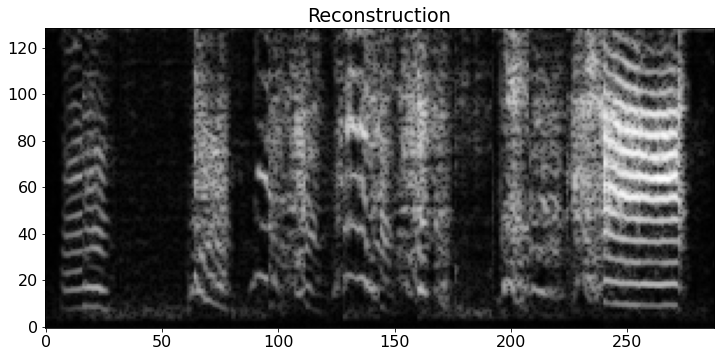

In [57]:
plt.figure(figsize=(12,6))
plt.imshow(rescale_spectrogram(X), origin='lower', cmap='gray')
plt.title('Reconstruction')
plt.show()

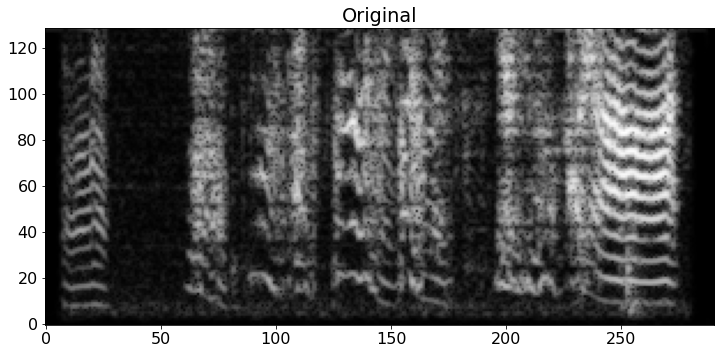

In [58]:
plt.figure(figsize=(12,6))
plt.imshow(rescale_spectrogram(spect), origin='lower', cmap='gray')
plt.title('Original')
plt.show()